# Creating the Vocabulary

In [1]:
import spacy
spacy_eng = spacy.load("en")
class Vocabulary:
    PAD_token = 0   # Used for padding short sentences
    SOS_token = 1   # Start-of-sentence token
    EOS_token = 2   # End-of-sentence token

    def __init__(self, name):
        self.name = name
        self.word2index = {'PAD': 0, 'SOS': 1, 'EOS': 2}
        self.word2count = {}
        self.index2word = {0: "PAD", 1: "SOS", 2: "EOS"}
        self.num_words = 3
        self.num_sentences = 0 
        self.longest_sentence = 0
    


    def add_word(self, word):
        if word not in self.word2index:
            # First entry of word into vocabulary
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            # Word exists; increase word count
            self.word2count[word] += 1
            
    def tokenizer(self,text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]
    
    def add_sentence(self, sentence):
        sentence_len = 0
        #for word in sentence.split(' '):
        for word in self.tokenizer(sentence):
            sentence_len += 1
            self.add_word(word)
        if sentence_len > self.longest_sentence:
            # This is the longest sentence
            self.longest_sentence = sentence_len
        # Count the number of sentences
        self.num_sentences += 1

    def to_word(self, index):
        return self.index2word[index]

    def to_index(self, word):
        return self.word2index[word]

In [2]:
import pandas as pd
import re
df = pd.read_csv('../input/flickr-image-dataset/flickr30k_images/results.csv',delimiter='|')
df[' comment'] = df[' comment'].str.lower()
df[' comment'].replace( { r'[^a-zA-Z0-9, ]' : '' }, inplace= True, regex = True)

# fixing an issue in the dataset.
df[' comment_number'][19999] = 4
df[' comment'][19999] = ' a dog runs across the grass '

# creating the vocabulary 
vocab = Vocabulary('test')

# adding words to the vocabulary 
for sentence in df[' comment']:
    vocab.add_sentence(sentence)

# converting the captions to tokens 
sent_idxs = []
captions = []
for idx, sentence in enumerate (df[' comment']):
    i = 0
    '''for word in sentence.split(' '):
        if i==0:
            sent_idxs.append(1)
        index = vocab.to_index(word)    
        if index != 3:    
            sent_idxs.append(index)
        elif index == 3 and i !=0:
            sent_idxs.append(2)
        i+=1'''
    #for word in sentence.split(' '):
    for word in vocab.tokenizer(sentence):
        sent_idxs.append(vocab.to_index(word))
        i+=1
    while i < ((vocab.longest_sentence) + 1):
        sent_idxs.append(0)
        i+=1
    captions.append(sent_idxs)
    sent_idxs = []

# converting list of word tokens to numpy array
import numpy as np
captions = np.array(captions)
captions.shape

(158915, 83)

In [3]:
# adding start and end tokens
for i in range(len(captions)):
    for j in range(1,84):
        if captions[i,j] == 0:
            if captions[i,j-1] == 3:
                captions[i,j-1] = 2
            else:
                captions[i,j] = 2
            break  
captions[:,0] = 1

# Loading the embeddings

In [4]:
import numpy as np 
vocabs = vocab.word2index.keys()

def load_embeds(root_dir):
    embeddings_index = dict()
    f = open(root_dir)

    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

    f.close()
    return embeddings_index
embeddings_index = load_embeds('../input/glove6b300dtxt/glove.6B.300d.txt')

In [5]:
embeddings_index['the']

array([ 4.6560e-02,  2.1318e-01, -7.4364e-03, -4.5854e-01, -3.5639e-02,
        2.3643e-01, -2.8836e-01,  2.1521e-01, -1.3486e-01, -1.6413e+00,
       -2.6091e-01,  3.2434e-02,  5.6621e-02, -4.3296e-02, -2.1672e-02,
        2.2476e-01, -7.5129e-02, -6.7018e-02, -1.4247e-01,  3.8825e-02,
       -1.8951e-01,  2.9977e-01,  3.9305e-01,  1.7887e-01, -1.7343e-01,
       -2.1178e-01,  2.3617e-01, -6.3681e-02, -4.2318e-01, -1.1661e-01,
        9.3754e-02,  1.7296e-01, -3.3073e-01,  4.9112e-01, -6.8995e-01,
       -9.2462e-02,  2.4742e-01, -1.7991e-01,  9.7908e-02,  8.3118e-02,
        1.5299e-01, -2.7276e-01, -3.8934e-02,  5.4453e-01,  5.3737e-01,
        2.9105e-01, -7.3514e-03,  4.7880e-02, -4.0760e-01, -2.6759e-02,
        1.7919e-01,  1.0977e-02, -1.0963e-01, -2.6395e-01,  7.3990e-02,
        2.6236e-01, -1.5080e-01,  3.4623e-01,  2.5758e-01,  1.1971e-01,
       -3.7135e-02, -7.1593e-02,  4.3898e-01, -4.0764e-02,  1.6425e-02,
       -4.4640e-01,  1.7197e-01,  4.6246e-02,  5.8639e-02,  4.14

In [6]:
import torch
def load_embed_weights(embeddings_index, embed_dim, vocab, vocab_size):
    matrix_len = vocab_size
    weights_matrix = np.zeros((matrix_len, embed_dim))
    words_found = 0

    for i, word in enumerate(vocab):
        try: 
            weights_matrix[i] = embeddings_index[word]
            words_found += 1
        except KeyError:
            weights_matrix[i] = np.random.normal(scale=0.6, size=(embed_dim, ))
    weights_matrix = torch.tensor(weights_matrix)
    return weights_matrix
weights_matrix = load_embed_weights(embeddings_index, 300, vocabs, vocab.num_words)
weights_matrix.shape

torch.Size([19997, 300])

# Some helper functions which we will be using later

In [7]:
def output_to_caption(outputs, index):
    preds = outputs[index]
    preds = torch.argmax(preds, dim = 1)
    preds = preds.cpu()
    preds = np.array(preds)
    for index in preds:
        if index == 2:
            break    
        if index != 1:    
            print(vocab.to_word(index), end = ' ')

def tensor_to_caption(preds, index):
    preds = preds[index].cpu()
    preds = np.array(preds)
    for index in preds:
        if index == 2:
            break
        if index != 1:    
            print(vocab.to_word(index), end = ' ')

def tensor_to_image(img_list, index):
    img = img_list[index].permute(1,2,0)
    plt.figure()
    plt.imshow(img.cpu())

# Creating the dataloader

a man in a black coat walks past a red spaceship with a parking ticket stuck to its window 

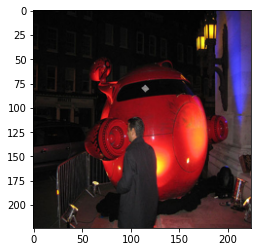

In [8]:
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from glob import glob
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


class Data(Dataset):

    def __init__(self, root_dir, captions):
        
        self.root_dir = root_dir
        self.df = pd.read_csv(root_dir+'results.csv', delimiter = '|')
        self.captions_tensor = torch.tensor(captions)
        self.captions = captions
        self.imgloc = self.df['image_name']
        self.img_list = glob(root_dir+'flickr30k_images/*')
    
    def __getcaption__(self,index):
        return self.captions[5*index]
    
    def __getitem__(self,index):
        
        img = self.root_dir+'flickr30k_images/'+ self.imgloc[5*index]
        caption = self.captions[5*index]
        img_tensor = (torch.tensor(np.array(Image.open(img).resize((224,224)))).permute(2,0,1) )/255
        return img_tensor, caption
    
    def __len__(self):
        return (len(self.img_list)-2)


data = Data('../input/flickr-image-dataset/flickr30k_images/', captions)
img, caption_tensor = data.__getitem__(69)
caption = data.__getcaption__(69)
plt.imshow(img.permute(1,2,0))
for idx in caption:
    if idx == 1:
        continue
    if idx !=2:
        print(vocab.to_word(idx), end =" ")
    else:
        break

a small baby boy sits in water with his hands up , splashing water droplets 

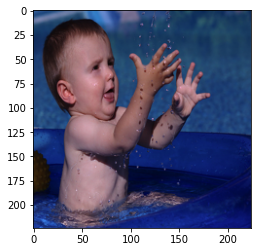

In [9]:
batch_size = 32
data_len = len(data)
trainset, valset = random_split(data, [int(0.8*data_len), (data_len - int(0.8*data_len))])
trainloader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle = True)
valloader = DataLoader(dataset=valset, batch_size=batch_size, shuffle = True)
for img_list, caption in trainloader:
    plt.imshow(img_list[4].permute(1,2,0))
    tensor_to_caption(caption,4)
    break

# Encoder

In [10]:
import torchvision
import torch.nn as  nn
model = torchvision.models.vgg16(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model = model.features[:30]
model

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

# Attention (soft)

In [18]:
class attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.fc = nn.Linear(hidden_dim*2, 1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim = 1)

    def forward(self, features, hidden_state):
        # features = [32,196,512], hidden_state = [32,512]
        hidden_state = hidden_state.unsqueeze(1)       #[32,1,512]
        ones = torch.ones(features.shape[1],1)  #[196,1]
        ones = ones.to(device)      
        hidden_state = ones @ hidden_state         #[32,196,512]

        combine = torch.cat((features, hidden_state), dim = 2)   #[32,196,1024]
        combine = combine.to(device)

        attn_weights = []

        for image in combine:
            #image = 196,1024
            out = self.relu(self.fc(image))  #[196,1]         
            out = out.squeeze(1)              #[196]
            attn_weights.append(out)

        # attn_weights = [32,196]
        attn_weights = torch.stack(attn_weights)    
        attn_weights = self.softmax(attn_weights)
        attn_weights = attn_weights.unsqueeze(1)  #[32,1,196]

        context = attn_weights @ features         #[32,1,512]

        return context.squeeze(1)                 #[32,512]

# Decoder

In [19]:
class Decoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, weights_matrix, device, attn, num_layers=1):
        super(Decoder, self).__init__()
        
        # define the properties
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        
        # lstm cell
        self.lstm_cell = nn.LSTMCell(input_size = embed_size + hidden_size, hidden_size=hidden_size)
    
        # output fully connected layer
        self.fc_out = nn.Linear(in_features = self.hidden_size*2, out_features = self.vocab_size)
    
        # embedding layer
        self.embed = nn.Embedding(num_embeddings = self.vocab_size, embedding_dim = self.embed_size)
        self.embed.weight.requires_grad = False
        self.embed.load_state_dict({'weight': weights_matrix})
         
    def forward(self, features, captions):


        # features = [32,196,512], captions = [32,num_words]
        
        # batch size
        batch_size = features.size(0)    # 32
        
        # init the hidden and cell states to zeros
        
        #hidden_state = torch.zeros((batch_size, self.hidden_size)).to(device)    #[32,512]
        #cell_state = torch.zeros((batch_size, self.hidden_size)).to(device)      #[32,512]
        
        hidden_state = torch.mean(features, dim = 1)    #[32,512]
        cell_state = torch.mean(features, dim = 1)      #[32,512]
        
        outputs = torch.empty((batch_size, captions.size(1), self.vocab_size)).to(device) #captions.size(1) is the number of words 
        # outputs = [32,num_words,vocab_size]
        
        # embed the captions
        captions_embed = self.embed(captions)    #[32,num_words,300]
        
        # pass the caption word by word
        for t in range(captions.size(1)):

            # getting the features of the image to be focussed on  
            context = attn(features, hidden_state)  #[32,512]

            # concatnating it with the input word
            inputs = torch.cat((context, captions_embed[:, t, :]), dim = 1) # [32,812] 
            
            #passing the combination through lstm
            hidden_state, cell_state = self.lstm_cell(inputs, (hidden_state, cell_state))
            
            out = torch.cat((context, hidden_state), dim = 1)
            # output of the attention mechanism
            out = self.fc_out(out)
            
            # build the output tensor
            outputs[:, t, :] = out      
    
        return F.log_softmax(outputs, dim = 2)
vocab_size = vocab.num_words
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
attn = attention(512)
attn = attn.to(device)
decoder = Decoder(300,512, vocab_size,weights_matrix, device, attn)

# Training function

In [20]:
import pyprind
def train(encoder, decoder, trainloader, criterion, optimizer_decoder, epoch, device):
    best_loss = 100
    train_loss = []
    bar = pyprind.ProgBar(len(trainloader), bar_char='█')
    for idx, (img_list, caption) in enumerate (trainloader):

        img_list = img_list.to(device)
        caption_target = caption[:,1:]    # skips SOS
        caption_train = caption[:,:-1]    # skips EOS
        caption_target, caption_train = caption_target.to(device).long(), caption_train.to(device).long()
        features = encoder(img_list) # [32,512,49,49]
        features.permute(0,2,3,1)    # [32,49,49,512]
        features = features.view(-1, 196, 512) # [32,196,512]
        outputs = decoder(features, caption_train)
        #optimizer_encoder.zero_grad()
        optimizer_decoder.zero_grad()
        
        loss = criterion(outputs.view(-1, vocab_size), caption_target.contiguous().view(-1))
        
        train_loss.append(loss.item())
        
        loss.backward()
        #optimizer_encoder.step()
        optimizer_decoder.step()
        bar.update()
        
        
    print('\ntrain loss : {}\n'.format(np.mean(train_loss)))
    if np.mean(train_loss) < best_loss:
        best_loss = np.mean(train_loss)
        torch.save(decoder.state_dict(), 'weights_decoder.pth')
    print('\npredicted caption:')
    output_to_caption(outputs, 1)
    print("\n\nactual caption:")
    tensor_to_caption(caption, 1)
    print()

# Training

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.NLLLoss(ignore_index = 0 )
criterion.to(device)
encoder = model
optimizer_decoder = torch.optim.Adam(decoder.parameters(), lr = 1e-2)
#optimizer_encoder = torch.optim.Adam(encoder.parameters(), lr = 1e-2)
encoder.to(device)
decoder.to(device)
epochs = 10
decoder.load_state_dict(torch.load('../input/weight-d/weights_decoder (1).pth'))
for epoch in range(epochs):
    train(encoder, decoder, trainloader, criterion, optimizer_decoder, epoch, device)
print("OVERALL TRAINING COMPLETE")
    

0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:17:41



train loss : 3.240142184383464


predicted caption:
two in playing in white outfits white standing tying a and , a backs 

actual caption:
ladies are dressed in white and are all tying white scarves on their heads 


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:14:49



train loss : 3.0607658800089133


predicted caption:
a crew in in section camera while the a greenhouse behind of town greenhouse products activities 

actual caption:
a man waves to the camera from inside a greenhouse section of a farm products store 


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:14:46



train loss : 2.9957184860541384


predicted caption:
a are a in a words shirt and a utensil 

actual caption:
there is lady with the white apron has an utensil standing over a wok , a man in blue shorts and blue shirt sitting down , a person in a pink shirt and others are in the background all in one place 


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:14:56



train loss : 2.9433259325207404


predicted caption:
a young dog is to jump trees in shaking and ground 

actual caption:
a furry dog attempts to dry itself by shaking the water off its coat 


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:14:30



train loss : 2.9023642815883806


predicted caption:
a man dog is running through the air 

actual caption:
a brown dog is running into the ocean as it chases a purple frisbee 


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:14:28



train loss : 2.8699581029280177


predicted caption:
a fighter in wearing in heels red tutu shirt and shirt and heels , wearing up the air while a a guitar cup 

actual caption:
a woman , dressed in a dark tutu , striped socks and heels , leaps in the air while holding a pink balloon 


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:14:30



train loss : 2.833924647697113


predicted caption:
a man in curled up to one on a hand 

actual caption:
a woman , curled up , sleeps in her seat on a bus 


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:14:29



train loss : 2.810012172902905


predicted caption:
a young boys are one with wearing a white shirt and jeans other is is chatting a green shirt and chatting dancing into of concrete retention dancing 

actual caption:
two young girls , one is wearing a striped shirt and the other one is wearing a yellow shirt , are leaping off a concrete retention wall 


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:14:28



train loss : 2.788432278723087


predicted caption:
a man dressed woman is against a bench with with a at the camera 

actual caption:
a casually dressed man leans on a building wall while staring at the traffic in front of him 


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:14:28



train loss : 2.7726294118653305


predicted caption:
a man man in a red shirt is standing a stone trunk with while 

actual caption:
a shirtless man wearing a white turban is climbing a tree trunk 
OVERALL TRAINING COMPLETE


# Checking the captions for random pictures in the valset

In [22]:
decoder.load_state_dict(torch.load('./weights_decoder.pth'))
for idx, (img_list, caption) in enumerate (valloader):

        img_list = img_list.to(device)
        caption_target = caption[:,1:]
        caption_train = caption[:,:-1]
        caption_target, caption_train = caption_target.to(device).long(), caption_train.to(device).long()
        features = encoder(img_list) # [32,512,49,49]
        features.permute(0,2,3,1)    # [32,49,49,512]
        features = features.view(-1, 196, 512) # [32,196,512]
        outputs = decoder(features, caption_train)
        break


predicted caption:
a man in a blue shirt and playing on on a chair of paper in , 

actual caption:
a man wearing a blue hoodie is outside writing on a piece of paper 


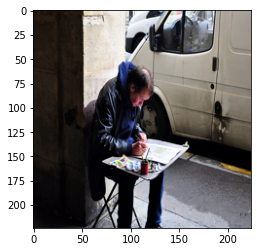

In [33]:
print('\npredicted caption:')
output_to_caption(outputs, 28)
print("\n\nactual caption:")
tensor_to_caption(caption, 28)
print()
tensor_to_image(img_list, 28)